# Results, section 2:

In [1]:
import os, sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_validate, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_Longitudinal/code/func/')
from proj_environment import set_proj_env
from func import mark_outliers, get_cmap, run_corr, get_fdr_p, perc_dev, evd, summarise_network

In [3]:
exclude_str = 't1Exclude'
parc_str = 'schaefer'
parc_scale = 400
primary_covariate = 'scanageYears'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str,
                                                                            parc_str = parc_str, parc_scale = parc_scale,
                                                                            primary_covariate = primary_covariate)

In [4]:
os.environ['NORMATIVEDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_Longitudinal/analysis/normative/t1Exclude/schaefer_400/scanageYears+sex_adj'

In [5]:
metrics = ('ct',)
phenos = ('Overall_Psychopathology','Mania','Depression','Psychosis_Positive','Psychosis_NegativeDisorg')

## Setup plots

In [6]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'talk', font_scale = 1)
cmap = sns.color_palette("pastel", 3)

## Load data

In [7]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'train.csv'))
df_train.set_index(['bblid', 'scanid', 'timepoint'], inplace = True); print(df_train.shape)
df_node_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid', 'timepoint'], inplace = True); print(df_node_train.shape)

# Test
df = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'test.csv'))
df.set_index(['bblid', 'scanid', 'timepoint'], inplace = True); print(df.shape)
df_node = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_test.csv'))
df_node.set_index(['bblid', 'scanid', 'timepoint'], inplace = True); print(df_node.shape)

# Normative model
smse = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node.columns)
z = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'Z.txt'), delimiter = ' ').transpose()
df_z = pd.DataFrame(data = z, index = df_node.index, columns = df_node.columns)

(995, 17)
(995, 400)
(1310, 17)
(1310, 400)


In [8]:
df.head()

TotalNtimepoints  TotalNtimepoints_new  sex  race  \
bblid scanid timepoint                                                      
80010 2894   1                         2                     2    1     1   
      7211   2                         2                     2    1     1   
80263 6635   1                         3                     3    2     2   
      8454   2                         3                     3    2     2   
      9127   3                         3                     3    2     2   

                        ethnicity  scanageMonths  scanageYears  \
bblid scanid timepoint                                           
80010 2894   1                  2            262          21.8   
      7211   2                  2            293          24.4   
80263 6635   1                  2            278          23.2   
      8454   2                  2            295          24.6   
      9127   3                  2            309          25.8   

                        mprage_antsCT_vol_TBV  averageManualRating  \
bblid scanid timepoint                                               
80010 2894   1                   1.383110e+06                  2.0   
      7211   2                   1.412140e+06                  2.0   
80263 6635   1                   1.110456e+06                  2.0   
      8454   2                   1.111174e+06                  2.0   
      9127   3                   1.090214e+06                  2.0   

                        dti32MeanRelRMS  Overall_Psychopathology     Mania  \
bblid scanid timepoint                                                       
80010 2894   1                 0.669736                 0.477260  0.234406   
      7211   2                 0.173847                -0.313878 -0.511101   
80263 6635   1                 0.290758                 0.366626  1.599553   
      8454   2                 0.774809                      NaN       NaN   
      9127   3                 0.385984                -0.501747 -0.423963   

                        Depression  Psychosis_Positive  \
bblid scanid timepoint                                   
80010 2894   1            0.411101           -0.765745   
      7211   2            2.357006            0.169766   
80263 6635   1            0.063244            1.666237   
      8454   2                 NaN                 NaN   
      9127   3            1.648215           -0.517196   

                        Psychosis_NegativeDisorg  train_test  sex_adj  
bblid scanid timepoint                                                 
80010 2894   1                          1.321310        True        0  
      7211   2                          0.555718        True        0  
80263 6635   1                         -1.151178        True        1  
      8454   2                               NaN        True        1  
      9127   3                          0.535995        True        1

# Characterizing the psychopathology phenotype data

Let's have a look at our psychopathology phenotype data, which are the continous DVs for our predictive model

In [9]:
print('N:', df.shape[0])

N: 1310


In [10]:
print('N w/ >=2 timepoints:', int(df.loc[df['TotalNtimepoints_new'] == 2,:].shape[0]/2 + df.loc[df['TotalNtimepoints_new'] == 3,:].shape[0]/3))
print('N w/ 3 timepoints:', int(df.loc[df['TotalNtimepoints_new'] == 3,:].shape[0]/3))

N w/ >=2 timepoints: 566
N w/ 3 timepoints: 178


In [11]:
# How much missing data have I got in the phenotypes?
for pheno in phenos:
    print('No. of NaNs for ' + pheno + ':', df.loc[:,pheno].isna().sum())

No. of NaNs for Overall_Psychopathology: 46
No. of NaNs for Mania: 46
No. of NaNs for Depression: 46
No. of NaNs for Psychosis_Positive: 46
No. of NaNs for Psychosis_NegativeDisorg: 46


In [12]:
my_bool = df.loc[:,phenos].isna().all(axis = 1)

In [13]:
# For now I'm going to just drop the NaN rows. Need to look into data imputation methods for dependent data
df = df.loc[~my_bool,:]

In [14]:
print('N:', df.shape[0])

N: 1264


Need recalculate the num timepoints now...

In [15]:
keep_me = ([1,2],[1,2,3])
idx_keep = []
idx_drop = []
for idx, data in df.groupby('bblid'):
    my_list = list(data.index.get_level_values(2).values)
    if my_list == keep_me[0] or my_list == keep_me[1]:
        idx_keep.append(idx)
    else:
        idx_drop.append(idx)

In [16]:
df = df.loc[idx_keep,:]

In [17]:
print('N:', df.shape[0])

N: 1219


In [18]:
for idx, data in df.groupby('bblid'):
    df.loc[idx,'TotalNtimepoints_new'] = int(data.shape[0])
df.loc[:,'TotalNtimepoints_new'] = df.loc[:,'TotalNtimepoints_new'].astype(int)

In [19]:
print('N w/ >=2 timepoints:', int(df.loc[df['TotalNtimepoints_new'] == 2,:].shape[0]/2 + df.loc[df['TotalNtimepoints_new'] == 3,:].shape[0]/3))
print('N w/ 3 timepoints:', int(df.loc[df['TotalNtimepoints_new'] == 3,:].shape[0]/3))

N w/ >=2 timepoints: 525
N w/ 3 timepoints: 169


Hasn't hurt my numbers too badly.

In [20]:
df_node = df_node.loc[df.index,:]
df_z = df_z.loc[df.index,:]

Now let's look at the distributions

In [21]:
# Generate booleans that subset the data by timepoints
idx_t1 = df.index.get_level_values(2) == 1
idx_t2 = df.index.get_level_values(2) == 2
idx_t3 = df.index.get_level_values(2) == 3

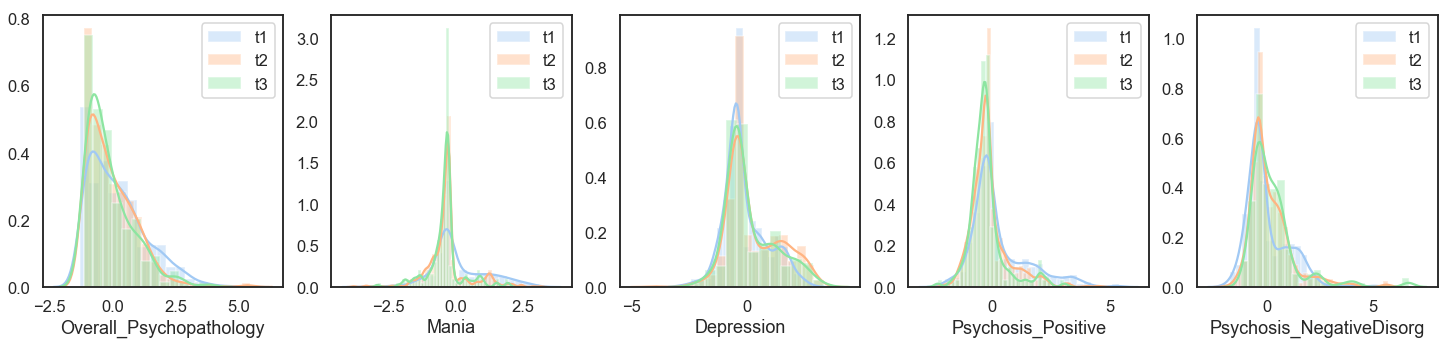

In [22]:
f, axes = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*5)
f.set_figheight(5)

for i, pheno in enumerate(phenos):
    sns.distplot(df.loc[idx_t1,pheno], ax = axes[i], color = cmap[0])
    sns.distplot(df.loc[idx_t2,pheno], ax = axes[i], color = cmap[1])
    sns.distplot(df.loc[idx_t3,pheno], ax = axes[i], color = cmap[2])
    axes[i].set_xlabel(pheno)
    axes[i].legend(['t1','t2','t3'])

Clear issues of normality.

In [23]:
for pheno in phenos:
    df.loc[:,pheno + '_n'] = sp.stats.yeojohnson(df.loc[:,pheno])[0]
#     df.loc[:,pheno + '_n'] = np.log(df.loc[:,pheno] + (df.loc[:,pheno].abs().max()+1))
#     df.loc[:,pheno + '_n'] = (df.loc[:,pheno] - df.loc[:,pheno].mean())/df.loc[:,pheno].std()  

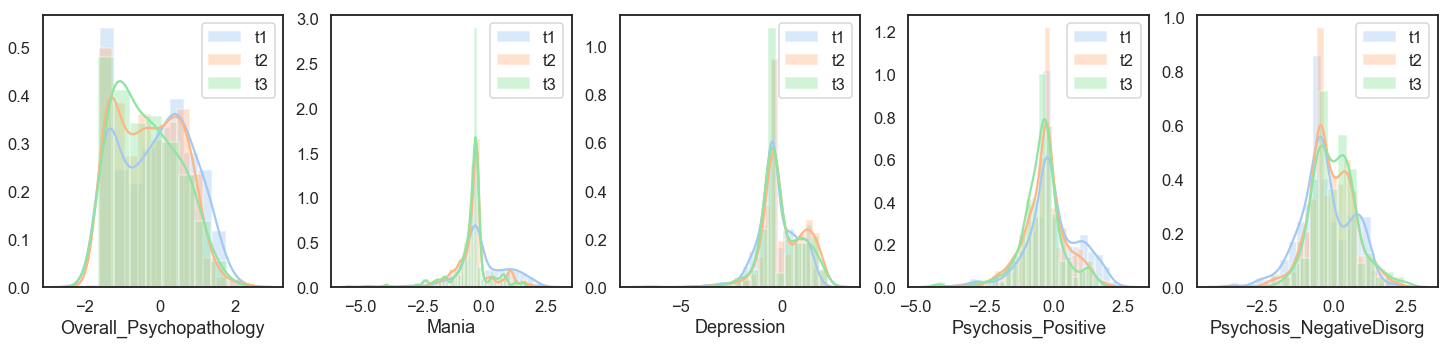

In [24]:
f, axes = plt.subplots(1,len(phenos))
f.set_figwidth(len(phenos)*5)
f.set_figheight(5)

for i, pheno in enumerate(phenos):
    sns.distplot(df.loc[idx_t1,pheno + '_n'], ax = axes[i], color = cmap[0])
    sns.distplot(df.loc[idx_t2,pheno + '_n'], ax = axes[i], color = cmap[1])
    sns.distplot(df.loc[idx_t3,pheno + '_n'], ax = axes[i], color = cmap[2])
    axes[i].set_xlabel(pheno)
    axes[i].legend(['t1','t2','t3'])

In [25]:
for i, pheno in enumerate(phenos):
#     print(np.var(df.loc[idx_t1,pheno + '_n']))
    x = df.loc[:,pheno + '_n']
    my_med = np.median(x)
    mad = np.median(abs(x - my_med))/1.4826
    print(mad)

0.5250346840381473
0.1752606987082045
0.334709387349124
0.30572416078132525
0.3488392585968229


# Feature selection

Starting by applying a set of reasonable baseline feature selection criteria:

1) Regions where there is a significant relationship between age and the regional brain features in the training set

2) Regions where the normative model was able to perform out of sample predictions (as index by standardized mean squared error < 1)

3) Regions where extreme deviations occur

### 1) Age effects

In [26]:
# age effect on training set
df_age_effect = run_corr(df_train[primary_covariate], df_node_train, typ = 'pearsonr'); df_age_effect['p_fdr'] = get_fdr_p(df_age_effect['p'])
if parc_str == 'lausanne':
    df_age_effect.drop(my_list, axis = 0, inplace = True)
age_alpha = 0.05
age_filter = df_age_effect['p_fdr'].values < age_alpha
age_filter.sum()

387

### 2) Normative model performance

In [27]:
smse_thresh = 1
smse_filter = df_smse.values < smse_thresh
smse_filter = smse_filter.reshape(-1)
smse_filter.sum()

388

### 3) Extreme deviations

At either time point 1 or 2

In [28]:
ed_filter_t1 = perc_dev(df_z.loc[idx_t1,:].transpose()) > 1
print(ed_filter_t1.sum())
ed_filter_t2 = perc_dev(df_z.loc[idx_t2,:].transpose()) > 1
print(ed_filter_t2.sum())

221
133


Combine all the filters into one

In [29]:
region_filter_1 = np.logical_and(age_filter,smse_filter)
region_filter_1.sum()

381

In [30]:
region_filter = np.logical_and(region_filter_1,np.logical_or(ed_filter_t1,ed_filter_t2))
region_filter.sum()

239

# Feature summaries

Alternatively could be to collapse over brain regions into single summary measures. There are a few obvious ways to do this: mean, extreme value stats. Let's look at a few!

In [31]:
df_node_summary = pd.DataFrame(index = df_node.index)
for metric in metrics:
    df_node_summary[metric+'_node_mean'] = df_node.loc[:,region_filter].filter(regex = metric, axis = 1).mean(axis = 1)
    df_node_summary[metric+'_z_mean'] = df_z.loc[:,region_filter].filter(regex = metric, axis = 1).mean(axis = 1)
    df_node_summary[metric+'_z_evd'] = evd(df_node.loc[:,region_filter].filter(regex = metric, axis = 1))
    df_node_summary[metric+'_z_evd_pos'] = evd(df_node.loc[:,region_filter].filter(regex = metric, axis = 1), sign = 'pos')
    df_node_summary[metric+'_z_evd_neg'] = np.abs(evd(df_node.loc[:,region_filter].filter(regex = metric, axis = 1), sign = 'neg'))

In [32]:
df_node_summary.head()

ct_node_mean  ct_z_mean  ct_z_evd  ct_z_evd_pos  \
bblid scanid timepoint                                                    
80010 2894   1             -0.124287   0.195717  0.919511      0.879735   
      7211   2             -0.208583   0.224473  0.891704      0.646670   
80537 2823   1             -0.106759   0.128890  1.237940      1.089329   
      9456   2             -0.313996   0.081150  1.110778      0.698013   
80557 3476   1             -0.298600  -0.335329  1.099674      0.897113   

                        ct_z_evd_neg  
bblid scanid timepoint                
80010 2894   1              0.777080  
      7211   2              0.891704  
80537 2823   1              1.082309  
      9456   2              1.110778  
80557 3476   1              1.099674

How do the summaries relate?

In [33]:
R = pd.DataFrame(index = df_node_summary.columns, columns = df_node_summary.columns)

for i_col in df_node_summary.columns:
    for j_col in df_node_summary.columns:
        R.loc[i_col,j_col] = sp.stats.pearsonr(df_node_summary[i_col],df_node_summary[j_col])[0]

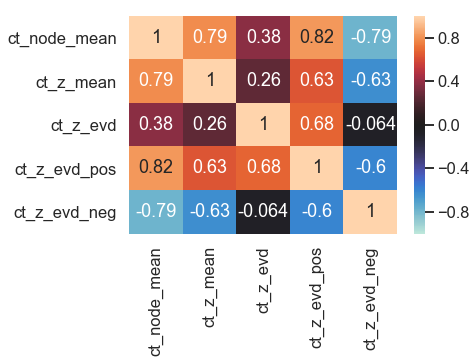

In [34]:
sns.heatmap(R.astype(float), annot = True, center = 0, vmax = 1, vmin = -1)

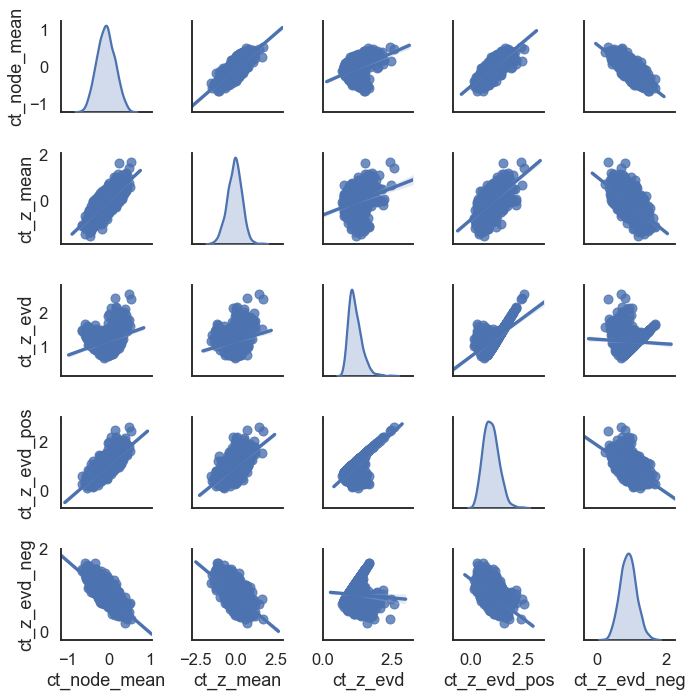

In [35]:
g = sns.pairplot(df_node_summary, kind = 'reg', diag_kind = 'kde', height = 2)

In [36]:
df_z_sys = summarise_network(df_z.loc[:,region_filter], parcel_loc[region_filter], yeo_idx[region_filter], metrics = ('ct',), method = 'mean')

In [37]:
R = pd.DataFrame(index = df_z_sys.columns, columns = df_z_sys.columns)

for i_col in df_z_sys.columns:
    for j_col in df_z_sys.columns:
        R.loc[i_col,j_col] = sp.stats.pearsonr(df_z_sys[i_col],df_z_sys[j_col])[0]

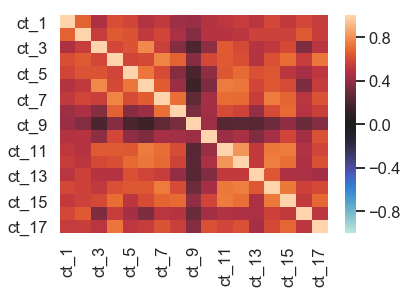

In [38]:
sns.heatmap(R.astype(float), annot = False, center = 0, vmax = 1, vmin = -1)

# Predictive model: regression

Here the goal is to use brain features (and demographics) from a given timepoint to predict each of our psychopathology phenotypes at a given timepoint.

In [39]:
df.columns

Index(['TotalNtimepoints', 'TotalNtimepoints_new', 'sex', 'race', 'ethnicity',
       'scanageMonths', 'scanageYears', 'mprage_antsCT_vol_TBV',
       'averageManualRating', 'dti32MeanRelRMS', 'Overall_Psychopathology',
       'Mania', 'Depression', 'Psychosis_Positive', 'Psychosis_NegativeDisorg',
       'train_test', 'sex_adj', 'Overall_Psychopathology_n', 'Mania_n',
       'Depression_n', 'Psychosis_Positive_n', 'Psychosis_NegativeDisorg_n'],
      dtype='object')

In [40]:
# First, we start by using T1 to predict T1
X = df_z_sys.loc[idx_t1,:].copy()
print(X.shape)

pheno = phenos[0]; print(pheno)
y = df.loc[idx_t1,pheno + '_n']

np.all(X.index.get_level_values(0) == y.index.get_level_values(0))

(525, 17)
Overall_Psychopathology


True

In [41]:
# Add continous*continous interaction terms
X_int = X.multiply(df.loc[idx_t1,'scanageMonths'], axis = 0)
X_int_names = list(X.columns)
X_int_names = [s + '_age' for s in X_int_names]
X_int.columns = X_int_names

In [42]:
# X = X_int.copy()
# X = pd.concat((X,X_int), axis = 1)

In [43]:
nan_filt = y.isna().values
X = X[~nan_filt]; print(X.shape)
y = y[~nan_filt]; print(y.shape)

sc = StandardScaler()
X_std = sc.fit_transform(X); print(X_std.shape)

(525, 17)
(525,)
(525, 17)


In [44]:
# How does the Ridge regression alpha param impact coefficients within training sample?
n_alphas = 50
alphas = np.logspace(-5, 5, n_alphas)
# alphas = 10**np.linspace(10,-2,100)*0.5
print(alphas[0],alphas[-1])
coefs = []
for a in alphas:
    mdl = Ridge(alpha=a)
    mdl.fit(X_std, y)
    coefs.append(mdl.coef_)

1e-05 100000.0


In [45]:
# inner_cv = KFold(n_splits=10, shuffle=True, random_state=0)
# outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)
inner_cv = KFold(n_splits=5, shuffle=False)
outer_cv = KFold(n_splits=5, shuffle=False)

In [46]:
# scoring = {'r2': 'r2', 'mse': make_scorer(mean_squared_error), 'mae': make_scorer(mean_absolute_error)}
scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error', 'mae': 'neg_mean_absolute_error'}

In [47]:
alpha_candidates = dict(alpha = alphas)
mdl = GridSearchCV(estimator=Ridge(), param_grid=alpha_candidates, cv=inner_cv, scoring = scoring, refit = 'r2')

In [48]:
# Fit the cross validated grid search on the data 
mdl.fit(X_std, y);

Text(0, 0.5, 'neg mae')

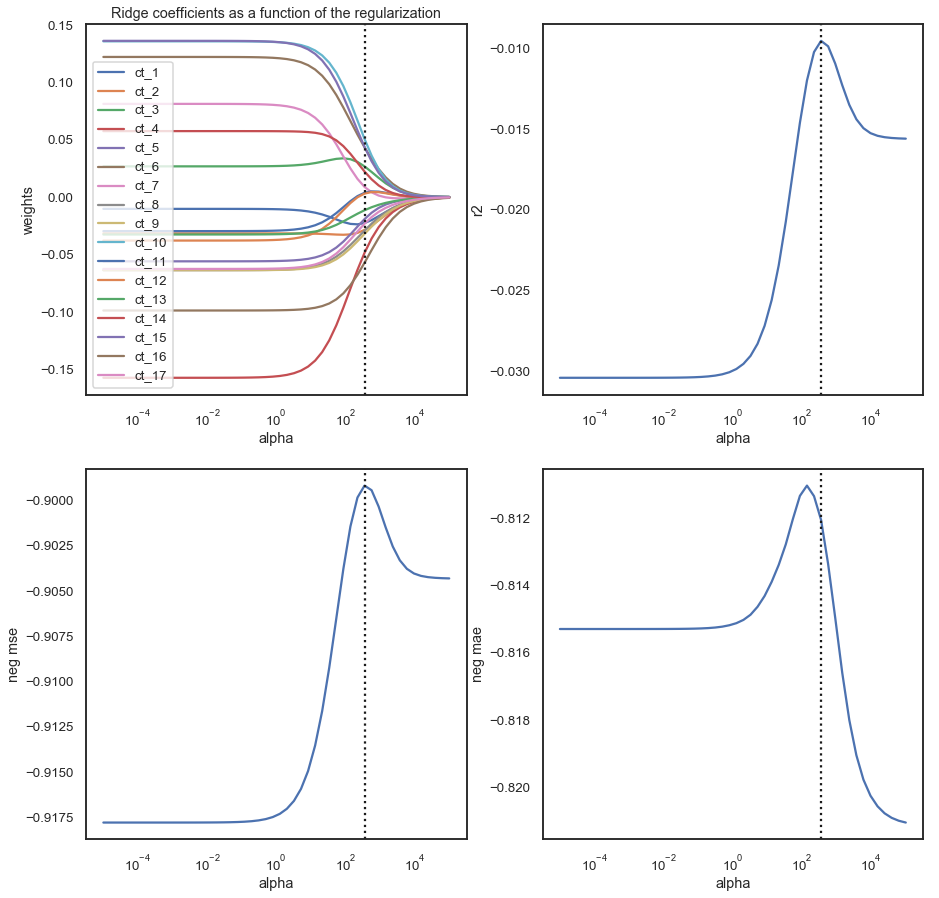

In [49]:
sns.set(style='white', context = 'talk', font_scale = 0.8)
f, ax = plt.subplots(2,2)
f.set_figwidth(15)
f.set_figheight(15)

ax[0,0].set_title('Ridge coefficients as a function of the regularization')
ax[0,0].plot(alphas, coefs)
ax[0,0].axvline(mdl.best_estimator_.alpha, linestyle = ':', color = 'k')
ax[0,0].set_xscale('log')
ax[0,0].set_xlabel('alpha')
ax[0,0].set_ylabel('weights')
ax[0,0].legend(list(X.columns))

ax[0,1].plot(alphas, mdl.cv_results_['mean_test_r2'])
ax[0,1].axvline(mdl.best_estimator_.alpha, linestyle = ':', color = 'k')
ax[0,1].set_xscale('log')
ax[0,1].set_xlabel('alpha')
ax[0,1].set_ylabel('r2')

ax[1,0].plot(alphas, mdl.cv_results_['mean_test_mse'])
ax[1,0].axvline(mdl.best_estimator_.alpha, linestyle = ':', color = 'k')
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('alpha')
ax[1,0].set_ylabel('neg mse')

ax[1,1].plot(alphas, mdl.cv_results_['mean_test_mae'])
ax[1,1].axvline(mdl.best_estimator_.alpha, linestyle = ':', color = 'k')
ax[1,1].set_xscale('log')
ax[1,1].set_xlabel('alpha')
ax[1,1].set_ylabel('neg mae')